Pedro Ivo Vasconcelos - TP

## **Capítulo 7**

1) A simulação do modelo linearizado é realizada dentro de um loop 'for' que atualiza os estados e calcula os valores de pH. Neste trecho do arquivo simrk_ph_teste_ee:

<div style="border: 1px solid; padding: 10px;">

```python
for k in range(ini, len(T)):
    kc = (k - 1) * Ts // h
    x[:, k], pH[k] = simrk_pH(x[:, k - 1], u1[k], u2[k], h, t[kc], par, Kas, Ts)

    for i in range(7):
        xl[i, k] = Ad[i, i] * xl[i, k - 1] + Bd[i, 0] * du1[k] + Bd[i, 1] * du2[k]
    
    # Verificar se os valores são finitos antes de calcular as raízes
    coefficients = [1, (Kas[0] - (xl[1, k] + x0[1])), 
                    (Kas[0] * Kas[1] - Kas[0] * (xl[1, k] + x0[1]) - Kas[2] - Kas[0] * (xl[2, k] + x0[2])), 
                    -(Kas[0] * Kas[2] + Kas[0] * Kas[1] * (xl[1, k] + x0[1]) + 2 * Kas[0] * Kas[1] * (xl[2, k] + x0[2])), 
                    -Kas[0] * Kas[1] * Kas[2]]
    
    if all(np.isfinite(coefficients)):
        p = np.roots(coefficients)
        ch = np.max(np.real(p))
        pHl[k] = -np.log10(ch)
    else:
        pHl[k] = np.nan  # Definir como NaN se os coeficientes não forem finitos
```
</div>

O trecho do código realiza duas tarefas basicamente:
- Atualiza os estados xl usando as matrizes discretizadas Ad e Bd.
- Calcula o pH com base nos estados atualizados, utilizando os coeficientes de um polinômio cujas raízes são encontradas para determinar o pH.

2- Rodando smirk_ph_teste_ee.py adicionando as linhas ao final antes de plotar resulta no abaixo:

<div style="border: 1px solid; padding: 10px;">

```python
op_point = x[:, -1]
print("Valores das variáveis de estado no ponto de operação:")
print(op_point)
```
</div>

Valores das variáveis de estado no ponto de operação:
[ -76.53707982   -2.73102377   58.58482429  -41.05832068  111.27257074
  -72.02857331 -130.35209109]

Valores das variáveis de estado no ponto de operação:
[ 200.93288893 -206.47440381  -43.20724559  -14.67633967   49.53193398
   24.5271484   -64.89402911]
Últimos 5 valores do ponto de operação
[10.57814618 10.57814637 10.57814652 10.57814663 10.57814672]


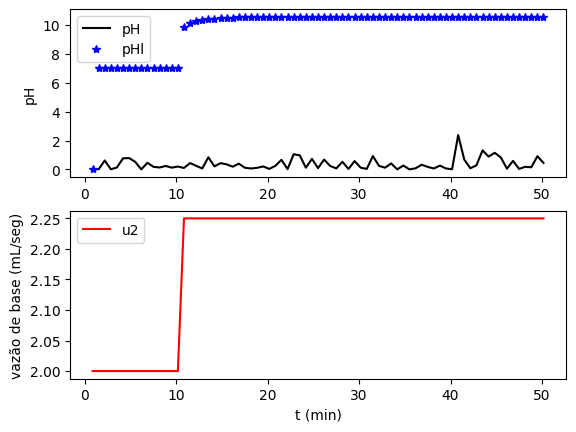

In [6]:
%run modelo_planta_ph/Modelo_de_pH_MATLAB_espaco_de_estados_linear/simrk_ph_teste_ee.py

3) Analisando o gráfico o valor e imprindos os últimos 5 valores do array, o pH será aproximadamente 10,58.

4) Os autovalores eles estão dentro e na margem do círculo de raio unitário explicitada pela matriz A = diag[0,031 0,791 0,791 1,0 1,0 1,0 1,0] o que indica que o sistema poderia ser marginalmente estável ou instável. E o sistema é marginalmente estável porque ele está convergindo ao ponto fixo no gráfico que é o ponto operação.

5) A matriz de controlabilidade é C\=\[B AB A<sup>2</sup>B⋯A<sup>n−1</sup>B\] logo:

In [9]:
import numpy as np
from numpy.linalg import matrix_rank

# Definindo as matrizes A e B
A = np.diag([0.031, 0.791, 0.791, 1.0, 1.0, 1.0, 1.0])
B = np.array([
    [0.1545, 0.1545],
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
    [-0.0303, 0],
    [0, 0],
    [0, -0.0303],
    [0, 0]
])

n = A.shape[0]
controllability_matrix = B
for i in range(1, n):
    controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A, i) @ B))

rank_of_controllability = matrix_rank(controllability_matrix)
print("Posto da matriz de controlabilidade:", rank_of_controllability)

if rank_of_controllability == n:
    print("O sistema é controlável.")
else:
    print("O sistema não é controlável.")

Posto da matriz de controlabilidade: 5
O sistema não é controlável.


A matriz não é controlável.

6) Para medir diretamente $x_{2}$ e $x_{3}$ e analisar a observalibilidade do par (A,C):


$C = \begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0
\end{bmatrix}$

E para que um sistema seja observável, a matriz de observabilidade deve ter posto completo, ou seja, o mesmo número de linhas que o sistema tem de estados.

$\mathcal{O} = \begin{bmatrix}
C \\
CA \\
CA^2 \\
\vdots \\
CA^{n-1}
\end{bmatrix}$

Realizando o cálculo:

In [10]:
import numpy as np
from numpy.linalg import matrix_rank

# Definindo a matriz A e a matriz de saída C
A = np.diag([0.031, 0.791, 0.791, 1.0, 1.0, 1.0, 1.0])
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0]
])

n = A.shape[0]
observability_matrix = C
for i in range(1, n):
    observability_matrix = np.vstack((observability_matrix, C @ np.linalg.matrix_power(A, i)))

rank_of_observability = matrix_rank(observability_matrix)
print("Posto da matriz de observabilidade:", rank_of_observability)

if rank_of_observability == n:
    print("O sistema é observável.")
else:
    print("O sistema não é observável.")

Posto da matriz de observabilidade: 2
O sistema não é observável.


O sistema é observável se o posto da matriz for igual ao número de estados (n) e será não observável se o posto for menor que o número de estados.

No contexto da planta de pH, que é a variável a ser controlada, se o sistema fosse observável, poderiamos inferir o estado completo do sistema a partir das medições de $x_{2}$ e $x_{3}$, o que é essencial para o controle eficaz do pH. Porém, o sistema não for observável, significa que não podemos determinar completamente o estado do sistema a partir das medições disponíveis, o que pode dificultar o controle preciso do pH.